In [8]:
using OrdinaryDiffEq, ModelingToolkit, DataDrivenDiffEq, SciMLSensitivity, DataDrivenSparse
using Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches, Plots
# Standard Libraries
using LinearAlgebra, Statistics

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs, LuxCUDA, Metal, SimpleDiffEq
gr()

#accesssing gpu (Metal)
gdev = gpu_device()


rng = StableRNG(1111)

StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)

In [9]:
# ODE problem definition for cannabis
function cannabis!(du, u, p, t)
    β, s, N = p
    du[1] = - β * (u[1] * u[3])/N
    du[2] =  β * (u[1] * u[3])/N - s * u[2]
    du[3] = s * u[2] 
end

cannabis! (generic function with 1 method)

In [15]:
#time interval: forcasted over one year period
tspan = (0,365)

#initial conditions for oregon
u0_oregon = [3305059;165252.95;1817]

#initial conditions for colorado
u0_colorado = [4108732;205436.60;2259.80]

#initial conditions for vermont 
u0_vermont = [327200;16360;179]

#parameter values for oregon
p_oregon = [0.05, 0.011, 3472129.73]

#parameter values for colorado
p_colorado = [0.05, 0.011, 431642.40]

#parameter values for vermont
p_vermont = [0.05, 0.011, 343739.96]

#problem definition for oregon
prob_oregon = ODEProblem(cannabis!, u0_oregon, tspan, p_oregon)

#problem definition for colorado
prob_colorado = ODEProblem(cannabis!, u0_colorado, tspan, p_colorado)

#problem definition for vermont
prob_vermont = ODEProblem(cannabis!, u0_vermont, tspan, p_vermont)

#setting up auto switching betwen stiff and non-stiff
tsidas_alg = AutoVern7(Rodas5())

#forecast for oregon
solution_oregon = solve(prob_oregon, tsidas_alg, abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

#forecast for colorado
solution_colorado = solve(prob_colorado, tsidas_alg, abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

#forecast for vermont
solution_vermont = solve(prob_vermont, tsidas_alg, abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

retcode: Success
Interpolation: 1st order linear
t: 1461-element Vector{Float64}:
   0.0
   0.25
   0.5
   0.75
   1.0
   1.25
   1.5
   1.75
   2.0
   2.25
   2.5
   2.75
   3.0
   ⋮
 362.25
 362.5
 362.75
 363.0
 363.25
 363.5
 363.75
 364.0
 364.25
 364.5
 364.75
 365.0
u: 1461-element Vector{Vector{Float64}}:
 [327200.0, 16360.0, 179.0]
 [327197.60274746007, 16317.465886263513, 223.93136627640138]
 [327194.6715958925, 16275.581745924917, 268.7466581825586]
 [327191.20793010714, 16234.344411109652, 313.44765878321726]
 [327187.21311629686, 16193.750741234131, 358.0361424690272]
 [327182.68850211956, 16153.797622849088, 402.5138750313934]
 [327177.63541677943, 16114.481969483779, 446.8826137368126]
 [327172.0551711083, 16075.80072149076, 491.14410740098435]
 [327165.9490576461, 16037.750845891693, 535.3000964622302]
 [327159.3183507216, 16000.329336223747, 579.3523130546864]
 [327152.1643065322, 15963.53321238683, 623.3024810810041]
 [327144.4881632238, 15927.359520491587, 667.152316

In [16]:
noise_magnitude = 5e-3

X_oregon = Array(solution_oregon)
X_colorado = Array(solution_colorado)
X_vermont = Array(solution_vermont)

t_oregon = solution_oregon.t
t_colorado = solution_colorado.t
t_vermont = solution_vermont.t

susceptible_oregon = X_oregon[1, :]
endemic_oregon = X_oregon[2, :]
users_oregon = X_oregon[3, :]
x̄_oregon = mean(X_oregon, dims = 2)
Xₙ_oregon = X_oregon .+ (noise_magnitude * x̄_oregon) .* randn(rng, eltype(X_oregon), size(X_oregon))

susceptible_colorado = X_colorado[1, :]
endemic_colorado = X_colorado[2, :]
users_colorado = X_colorado[3, :]
x̄_colorado = mean(X_colorado, dims = 2)
Xₙ_colorado = X_colorado .+ (noise_magnitude * x̄_colorado) .* randn(rng, eltype(X_colorado), size(X_colorado))

susceptible_vermont = X_vermont[1, :]
endemic_vermont = X_vermont[2, :]
users_vermont = X_vermont[3, :]
x̄_vermont = mean(X_vermont, dims = 2)
Xₙ_vermont = X_vermont .+ (noise_magnitude * x̄_vermont) .* randn(rng, eltype(X_vermont), size(X_vermont))

3×1461 Matrix{Float64}:
     3.27363e5      3.27968e5      3.26281e5  …   1374.98         240.086
 16468.3        16465.9        16436.0           54642.6        54549.7
    56.7895      -129.26        -234.085             2.87963e5      2.89339e5

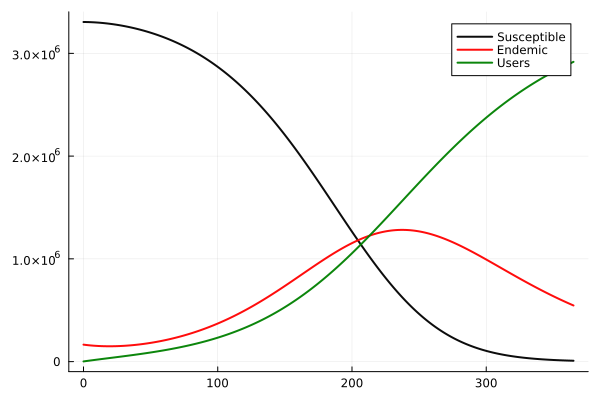

In [17]:
plot(t_oregon,susceptible_oregon, alpha = 0.95, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_oregon,endemic_oregon, alpha = 0.95, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t_oregon,users_oregon, alpha = 0.95, color = :green, label = ["Users" nothing], linewidth=2)

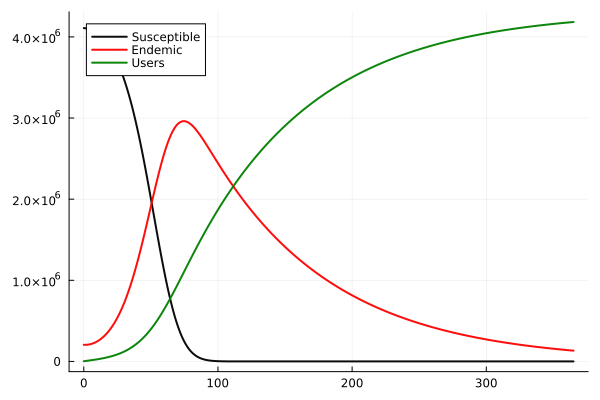

In [18]:
plot(t_colorado,susceptible_colorado, alpha = 0.95, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_colorado,endemic_colorado, alpha = 0.95, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t_colorado,users_colorado, alpha = 0.95, color = :green, label = ["Users" nothing], linewidth=2)

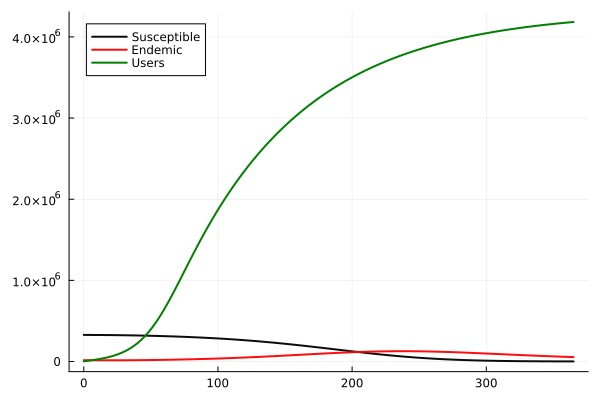

In [19]:
plot(t_vermont,susceptible_vermont, alpha = 0.95, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t_vermont,endemic_vermont, alpha = 0.95, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t_vermont,users_colorado, vermont = 0.95, color = :green, label = ["Users" nothing], linewidth=2)

In [ ]:
function marijuana!(du, u, p, t)
    β, γ, s, N = p
    du[1] = - β * (u[1] * u[3])/N
    du[2] =  (β * (u[1] * u[3])/N) - (s * u[2])
    du[3] = s * u[2] - γ * u[3]
    du[4] = γ * u[3]
end

In [ ]:
tspan = (0.0f0,365.0f0)
println(tspan)
u0 = Float32.([3305059;36686;19186.78;0])
p_ = Float32.([0.05, 0.105625, 0.011, 3360931.78])
prob = ODEProblem(marijuana!, u0, tspan, p_)
# tsidas_alg = AutoVern7(Rodas5())
solution = solve(prob, Rosenbrock23(), abstol = 1e-12, reltol = 1e-12, saveat = 0.25)

In [ ]:
X = Array(solution)
t = gdev(Array(solution.t))
Xdev= gdev(Array(solution))
susceptible = Xdev[1, :] 
endemic = Xdev[2, :] 
users = Xdev[3, :] 
treatment = Xdev[4, :]
x̄ = mean(X, dims = 2)
noise_magnitude = 5e-3
noise_vec = X .+ (noise_magnitude * x̄) .* randn(rng, eltype(X), size(X))
Xₙ = map(Float32, noise_vec)

In [ ]:
plot(t,susceptible, alpha = 0.75, color = :black, label = ["Susceptible" nothing], linewidth=2)
plot!(t,endemic, alpha = 0.75, color = :red, label = ["Endemic" nothing], linewidth=2)
plot!(t,users, alpha = 0.75, color = :green, label = ["Users" nothing], linewidth=2)
plot!(t,treatment, alpha = 0.75, color = :blue, label = ["Treatment" nothing], linewidth=2)

In [ ]:
println(t)
s = scatter!(t, transpose(Xₙ), color = :red, label = ["Noisy Data" nothing])

In [ ]:
# Define the ReLU activation function
# function myrelu(x)
#     return max(0, x)
# end
rbf(x) = exp.(-(x .^ 2))
# rbf(x) = myrelu(x)
const U = Lux.Chain(Lux.Dense(4, 16, rbf),Lux.Dense(16, 1))

# Get the initial parameters and state variables of the model
p, st = Lux.setup(rng, U)
const _st = st


In [ ]:
# Define the hybrid model (Neural Network)
function ude_dynamics!(du, u, p, t, p_true)
    û = U(u, p, _st)[1] # Network prediction
    du[1] = -p_true[1] * (u[1] * u[3])/p_true[4]
    du[2] =  (p_true[1] * (u[1] * u[3])/p_true[4]) - (p_true[3] * û[1])
    du[3] = p_true[3] * u[2] - p_true[2] * u[3]
    du[4] = u[3] * û[1]
end

In [ ]:
# Closure with the known parameter
nn_dynamics!(du, u, p, t) = ude_dynamics!(du, u, p, t, p_)
# Define the problem
prob_nn = ODEProblem(nn_dynamics!, Xₙ[:, 1], tspan, p)

function predict(θ, X = Xₙ[:, 1], T = t)
    _prob = remake(prob_nn, u0 = X, tspan = (T[1], T[end]), p = θ)
    Array(solve(_prob, Vern7(), saveat = T,
                abstol = 1e-6, reltol = 1e-6,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end

In [ ]:
function loss(θ)
    X̂ = predict(θ)
    mean(abs2, Xₙ .- X̂)
end

losses = Float32[]

callback = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float32}(p))

res1 = Optimization.solve(optprob, OptimizationOptimisers.Adam(), callback = callback, maxiters = 7000, abstol = 1e-20, reltol = 1e-11)
println("Training loss after $(length(losses)) iterations: $(losses[end])")

optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2,  LBFGS(linesearch = HagerZhang()), callback = callback, maxiters = 2000)
println("Final training loss after $(length(losses)) iterations: $(losses[end])")

In [ ]:
# Rename the best candidate
p_trained = res2.u

# Plot the losses
pl_losses = plot(1:5000, losses[1:5000], yaxis = :log10, xaxis = :log10,
                 xlabel = "Iterations", ylabel = "Loss", label = "ADAM", color = :blue)
plot!(5001:length(losses), losses[5001:end], yaxis = :log10, xaxis = :log10,
      xlabel = "Iterations", ylabel = "Loss", label = "LBFGS", color = :red)

In [ ]:
## Analysis of the trained network
# Plot the data and the approximation
ts = first(solution.t):(mean(diff(solution.t)) / 2):last(solution.t)
X̂ = predict(p_trained, Xₙ[4, :], ts)
# Trained on noisy data vs real solution
pl_trajectory = plot(ts, transpose(X̂), xlabel = "t", ylabel = "T(t)", color = :red,
                     label = ["UDE Approximation" nothing])
plot!(solution.t, transpose(Xₙ), color = :black, label = ["Measurements" nothing])
# scatter!(solution.t, transpose(Xₙ), color = :white, label = ["Measurements" nothing])

In [ ]:
# Ideal unknown interactions of the predictor
Ȳ = [p_[2] * (X̂[1, :] .* X̂[2, :])'; p_[3] * (X̂[1, :] .* X̂[2, :])']
# Neural network guess
Ŷ = U(X̂, p_trained, st)[1]

pl_reconstruction = plot(ts, transpose(Ŷ), xlabel = "t", ylabel = "U(x,y)", color = :red,
                         label = ["UDE Approximation" nothing])
plot!(ts, transpose(Ȳ), color = :black, label = ["True Interaction" nothing])

In [ ]:
# Plot the error
pl_reconstruction_error = plot(ts, norm.(eachcol(Ȳ - Ŷ)), yaxis = :log, xlabel = "t",
                               ylabel = "L2-Error", label = nothing, color = :red)
pl_missing = plot(pl_reconstruction, pl_reconstruction_error, layout = (2, 1))
pl_overall = plot(pl_trajectory, pl_missing)